In [83]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import itertools
import pprint

In [88]:
class LSTM():
    
    def __init__(self):
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.LSTM(32))
        self.model.add(tf.keras.layers.LSTM(16,activation = 'relu'))
        self.model.add(tf.keras.layers.Dense(1))

        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

        
    def train(self,training_data,EOPCHS, EVALUATION_INTERVAL, validation_data):
        self.model.fit(training_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation_data, validation_steps=50)

    
    def predict(self,data):
        return self.model.predict(data)


In [89]:
def DataLoader(fname):
    df = pd.read_csv(fname)
    data = df['Price']
    data.index = df['Time']
    
    return data
       

def normalise_data(data):
    data = tf.keras.utils.normalize(data)
    return data[0]

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data  = []
    labels = []
    
    start_index += history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indicies = range(i-history_size, i)
        reshaped_data = np.reshape(dataset[indicies], (history_size,1))
        data.append(reshaped_data)
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length,0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()
    



def preprocess(fname):
    data = DataLoader(fname)
    print(data.plot(subplots=True))
    data_vals = data.values
    data_vals = normalise_data(data_vals)
    
    TRAIN_SPLIT = int(0.7*len(midprice_data))
    univariate_past_history = 40
    univariate_future_target = 0

    x_train_uni, y_train_uni = univariate_data(data_vals, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
    x_val_uni, y_val_uni = univariate_data(data_vals, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
    
    BATCH_SIZE = 256
    BUFFER_SIZE = 1000

    train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    
    return [train_univariate, val_univariate]

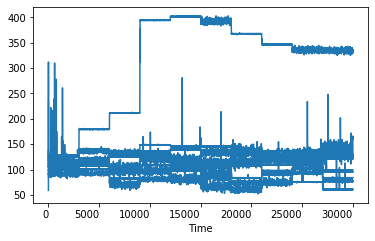

In [90]:
from os import listdir

def find_midprice_filenames( path_to_dir, suffix=".csv" , prefix ='midprice'):
    filenames = listdir(path_to_dir)
    return [ path_to_dir + filename for filename in filenames if (filename.endswith( suffix) and filename.startswith(prefix)) ]

fnames = find_midprice_filenames("../BSE/")


#returns list of [train_univariate, val_univariate]
results = list(map(preprocess,fnames))




In [91]:
EVALUATION_INTERVAL = 300
EPOCHS = 10
midprice_model = LSTM()

for result in results:
    train_univariate = result[0]
    val_univariate   = result[1]
    midprice_model.train(train_univariate, EPOCHS, EVALUATION_INTERVAL, val_univariate )


ValueError: Input 0 of layer lstm_15 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 32]

In [ ]:
for result in results:
    val_univariate = result[1]
    for x, y in val_univariate.take(3):

        prediction = midprice_model.predict(x)[0]
        print (prediction)
        plot = show_plot([x[0].numpy(), y[0].numpy(),
                    prediction], 0, 'Simple LSTM model')

    